In [1]:
# Utils packages
import ast
from datetime import datetime
from pathlib import Path, PurePath
from typing import List

# Visualization packages
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
from PIL import Image

# Analysis packages
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

# Model packages
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers

## Read dataset file

In [2]:
DATA_PATH = "data" # Directory to drop collected data.

In [3]:
hentais_df = pd.read_json(
    Path(DATA_PATH) / "preprocessed" / "metadata.ndjson",
    orient="records",
    lines=True
)
hentais_df

,id,title,num_favorites,tag,group,parody,character,language,artist,category,num_pages,filenames
0,352188,Boku wa Chiisana Succubus no Shimobe - I am a ...,5016,"[wings, garter belt, group, uncensored, story ...",[],[],[],"[english, translated]",[tamano kedama],[manga],195,"[data\preprocessed\352188\1.jpg, data\preproce..."
1,339950,Papakatsu de Deatta Ko ga Inma kamo Shirenai,10139,"[sole male, beauty mark, lolicon, mouth mask, ...",[kedama gyuunyuu],[original],[],"[english, translated]",[tamano kedama],[doujinshi],15,"[data\preprocessed\339950\1.jpg, data\preproce..."
2,295471,Lily Spice,5456,"[sole male, dark skin, demon girl, gloves, lac...",[kedama gyuunyuu],[original],[],"[english, translated]",[tamano kedama],[doujinshi],30,"[data\preprocessed\295471\1.jpg, data\preproce..."
3,248327,Eld Marriage,3716,"[sole male, lolicon, sole female, stockings, t...",[kedama gyuunyuu],[azur lane],[eldridge],"[english, translated]",[tamano kedama],[doujinshi],22,"[data\preprocessed\248327\1.jpg, data\preproce..."
4,214344,Majo no Watashi ga Saimin nanka ni Kakaru wake...,4945,"[anal, dog girl, garter belt, lolicon, mind co...",[kedama gyuunyuu],[touhou project],[patchouli knowledge],"[english, translated]",[tamano kedama],[doujinshi],22,"[data\preprocessed\214344\1.jpg, data\preproce..."
...,...,...,...,...,...,...,...,...,...,...,...,...
3739,19145,Fuuka Meiga za Nihon date: Roommate no Hime go...,17,"[lolicon, yuri]",[bolze.],[mai-otome],"[shizuru fujino, erstin ho, nina wang, yohko h...",[japanese],[rit.],[doujinshi],18,"[data\preprocessed\19145\1.jpg, data\preproces..."
3740,243825,Count2.4 CGF Soushuuhen,1167,"[bondage, anal, gag, nakadashi, stockings]",[count2.4],[the idolmaster],"[koume shirasaka, mayu sakuma, mika jougasaki,...",[japanese],[nishi],[doujinshi],140,"[data\preprocessed\243825\1.jpg, data\preproce..."
3741,230693,ふたりきり,70,"[anal, dark skin, males only, shotacon, yaoi, ...",[],[dragon ball z],"[son goku, turles]",[japanese],[],[doujinshi],15,"[data\preprocessed\230693\1.jpg, data\preproce..."
3742,115897,Otoko no Tatakai 18,49,"[fundoshi, humiliation, full censorship, femdo...",[ito ichizo shouten],[],[],[japanese],[ito ichizo],[doujinshi],17,"[data\preprocessed\115897\1.jpg, data\preproce..."


## Data preparation

The following preparation steps aim to create training and validation sets that can be used for machine learning.
For example, if a hentai tag is rare, we will remove it from the target variable.
The model will not learn how to predict that genre if the data covering it is insufficient.

In [4]:
def plot_label_frequency(labels):
    style.use("fivethirtyeight")
    plt.figure(figsize=(12, 16))
    sns.barplot(y=labels.index.values, x=labels, order=labels.index)
    plt.title("Labels", fontsize=14)
    plt.xlabel("Frequency")
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

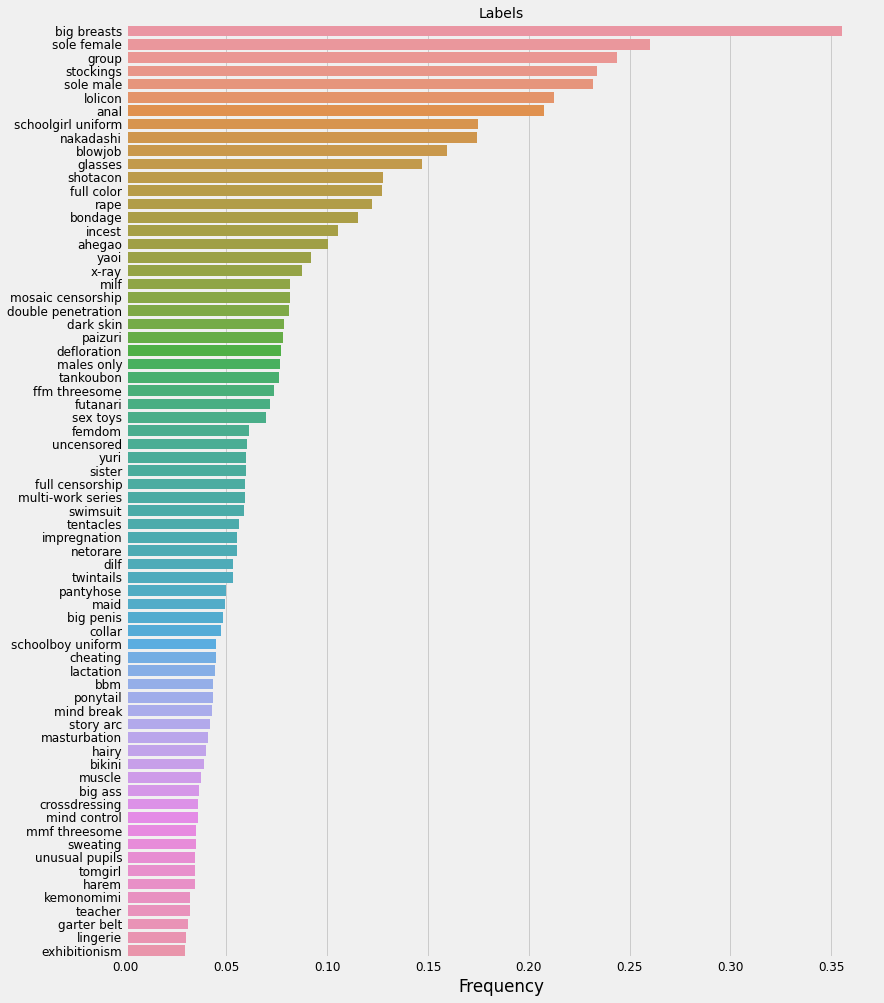

In [5]:
# Get label frequencies in descending order
label_freq = hentais_df["tag"].explode().value_counts()
label_freq = label_freq / len(hentais_df["tag"])
plot_label_frequency(label_freq.head(70))

## Remove infrequent labels

We will consider as a rare label every label that is covered by less than 5% in our dataset.
We will assume that rare labels are very hard to predict due to lack of sufficient data.
The model that we will train later will not focus on predicting these labels.
So, we need to make some transformation in the label column (tag) where we ignore infrequent labels by hiding them.

In [6]:
rare_label_df = label_freq[label_freq < 0.01]
rare_label_df

tomboy                0.009882
military              0.009615
crotch tattoo         0.009615
incomplete            0.009348
shibari               0.009348
                        ...   
invisible             0.000267
akigami satoru        0.000267
unusual insertions    0.000267
minotaur              0.000267
western               0.000267
Name: tag, Length: 395, dtype: float64

Remove the rare tags

In [7]:
hentais_df = hentais_df.assign(
    tag=hentais_df["tag"].apply(lambda x: [l for l in x if l not in rare_label_df])
)
hentais_df

,id,title,num_favorites,tag,group,parody,character,language,artist,category,num_pages,filenames
0,352188,Boku wa Chiisana Succubus no Shimobe - I am a ...,5016,"[garter belt, group, uncensored, story arc, na...",[],[],[],"[english, translated]",[tamano kedama],[manga],195,"[data\preprocessed\352188\1.jpg, data\preproce..."
1,339950,Papakatsu de Deatta Ko ga Inma kamo Shirenai,10139,"[sole male, beauty mark, lolicon, nakadashi, p...",[kedama gyuunyuu],[original],[],"[english, translated]",[tamano kedama],[doujinshi],15,"[data\preprocessed\339950\1.jpg, data\preproce..."
2,295471,Lily Spice,5456,"[sole male, dark skin, demon girl, gloves, lac...",[kedama gyuunyuu],[original],[],"[english, translated]",[tamano kedama],[doujinshi],30,"[data\preprocessed\295471\1.jpg, data\preproce..."
3,248327,Eld Marriage,3716,"[sole male, lolicon, sole female, stockings, t...",[kedama gyuunyuu],[azur lane],[eldridge],"[english, translated]",[tamano kedama],[doujinshi],22,"[data\preprocessed\248327\1.jpg, data\preproce..."
4,214344,Majo no Watashi ga Saimin nanka ni Kakaru wake...,4945,"[anal, garter belt, lolicon, mind control, sex...",[kedama gyuunyuu],[touhou project],[patchouli knowledge],"[english, translated]",[tamano kedama],[doujinshi],22,"[data\preprocessed\214344\1.jpg, data\preproce..."
...,...,...,...,...,...,...,...,...,...,...,...,...
3739,19145,Fuuka Meiga za Nihon date: Roommate no Hime go...,17,"[lolicon, yuri]",[bolze.],[mai-otome],"[shizuru fujino, erstin ho, nina wang, yohko h...",[japanese],[rit.],[doujinshi],18,"[data\preprocessed\19145\1.jpg, data\preproces..."
3740,243825,Count2.4 CGF Soushuuhen,1167,"[bondage, anal, gag, nakadashi, stockings]",[count2.4],[the idolmaster],"[koume shirasaka, mayu sakuma, mika jougasaki,...",[japanese],[nishi],[doujinshi],140,"[data\preprocessed\243825\1.jpg, data\preproce..."
3741,230693,ふたりきり,70,"[anal, dark skin, males only, shotacon, yaoi]",[],[dragon ball z],"[son goku, turles]",[japanese],[],[doujinshi],15,"[data\preprocessed\230693\1.jpg, data\preproce..."
3742,115897,Otoko no Tatakai 18,49,"[full censorship, femdom, dark skin, bloomers,...",[ito ichizo shouten],[],[],[japanese],[ito ichizo],[doujinshi],17,"[data\preprocessed\115897\1.jpg, data\preproce..."


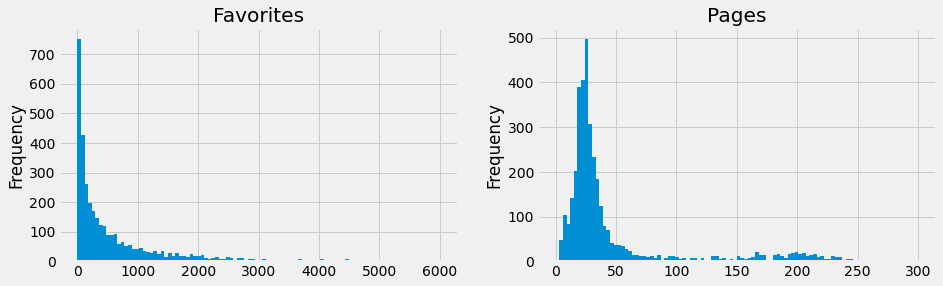

In [8]:
plt.figure(figsize=(14, 4))
hentais_df["num_favorites"].plot.hist(
    ax=plt.subplot(1, 2, 1),
    bins=100,
    range=(0, 6000),
    title="Favorites"
)
hentais_df["num_pages"].plot.hist(
    ax=plt.subplot(1, 2, 2),
    bins=100,
    range=(0, 300),
    title="Pages"
)
plt.show()

In [9]:
print("Most frequent pages numbers: ", (hentais_df["num_pages"]
                                        .value_counts()
                                        .idxmax()))

Most frequent pages numbers:  26


Trim filenames into timesteps

In [10]:
IMG_TIMESTEP = 20 # Number of pages to build a contextual classification of hentai tags

In [11]:
hentais_df = hentais_df.assign(
    filenames=hentais_df.apply(lambda x: x["filenames"][:IMG_TIMESTEP], axis=1)
)

## Image examples

Let's display some examples of training images.

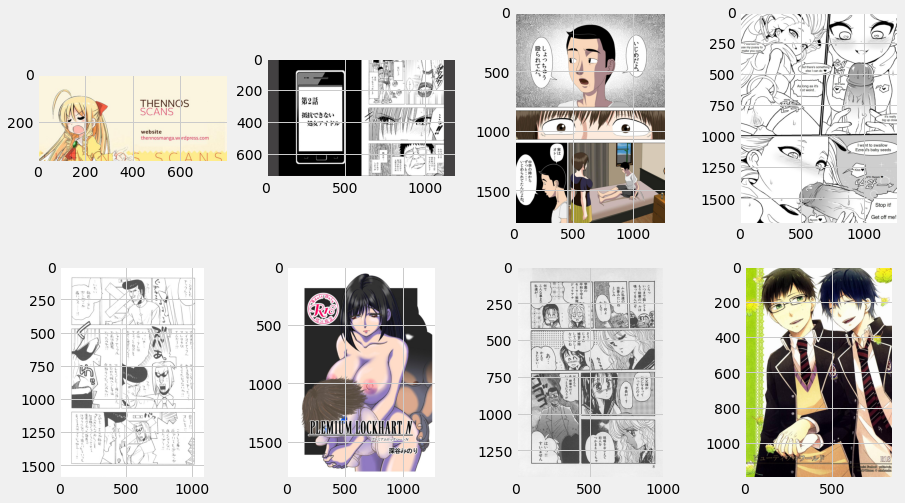

In [12]:
nobjs = 8 # Maximum number of images to display
ncols = 4 # Number of columns in display
nrows = nobjs // ncols # Number of rows in display

plt.figure(figsize=(14, 4 * nrows))
filenames_df = hentais_df["filenames"].explode().sample(nrows * ncols)
for i, filename in enumerate(filenames_df):
    ax = plt.subplot(nrows, ncols, i + 1)
    ax.imshow(Image.open(filename))

## Train / val split

Splitting the modeling data into training and validation is common in machine learning practice.
We will be allocating 80% of the images for training and 20% for validation.
Usually, we keep a final test set to communicate performance results but we will not really need it in this notebook.

In [13]:
X, Y = hentais_df["filenames"].to_numpy(), hentais_df["tag"].to_numpy()
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=44)
print("Number of hentais for training: {}".format(len(X_train)))
print("Number of hentais for validation: {}".format(len(X_val)))

Number of hentais for training: 2995
Number of hentais for validation: 749


## Label encoding

The original targets are lists of strings that can be easily understood by humans.
But, if we want to build and train a neural network we need to create binary labels (multi-hot encoding).
This is critical for multi-label classification.

In order to binarize our labels, we will be using scikit-learn's MultiLabelBinarizer.

In [14]:
# Fit the multi-label binarizer on the training set
mlb = MultiLabelBinarizer()
mlb.fit(Y)

# Analyze the number of labels in the dataset for
# the output layer of our subsequent model.
labels_df = pd.Series(mlb.classes_)
labels_df

0         ahegao
1           anal
2      anthology
3           bald
4            bbm
         ...    
130    virginity
131      webtoon
132        x-ray
133         yaoi
134         yuri
Length: 135, dtype: object

Analyze the number of labels in the dataset for the output layer of our subsequent model.

In [15]:
nlabels = len(labels_df)

Transform the targets of the training and test sets.

In [16]:
y_train_bin = mlb.transform(y_train)
y_val_bin = mlb.transform(y_val)

## Establish a baseline

Following development best practices, you should establish a baseline. The simplest baseline is predicting the most average classes.

In [17]:
y_bin = mlb.transform(hentais_df["tag"])
print("Average class prediction baseline: {0:.0%}".format(np.mean(y_bin)))

Average class prediction baseline: 5%


## Input pipeline

If you are familiar with keras.preprocessing you may know the image data iterators (E.g. ImageDataGenerator, DirectoryIterator).
These iterators are convenient for multi-class classfication where the image directory contains one subdirectory for each class.
But, in the case of multi-label classification, having an image directory that respects this structure is not possible because one observation can belong to multiple classes at the same time.

That is where the tf.data API has the upper hand.
- It is faster.
- It provides fine-grained control.
- It is well integrated with the rest of TensorFlow.

We first need to write some function to parse image files and generate a tensor representing the features and a tensor representing the labels.
- In this function we can resize the image to adapt to the input expected by the model.
- We can also normalize the pixel values to be between 0 and 1. This is a common practice that helps speed up the convergence of training.

If we consider every pixel as a feature, we would like these features to have a similar range so that the gradients don't go out of control and that we only need one global learning rate multiplier.

In [18]:
IMG_SIZE = 224 # Specify height and width of image to match the input format of the model
CHANNELS = 3 # Keep RGB color channels to match the input format of the model

In [19]:
def read_image_fn(filename: tf.Tensor):
    # Read an image from a file
    image_string = tf.io.read_file(filename)
    # Decode it into a dense vector
    image_decoded = tf.image.decode_image(
        image_string,
        channels=CHANNELS,
        expand_animations=False
    )
    # Resize it to fixed shape
    image_resized = tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE])
    # Normalize it from [0, 255] to [0.0, 1.0]
    image_normalized = image_resized / 255.0
    return image_normalized

def read_example_fn(filenames: tf.Tensor, label: tf.Tensor):
    return tf.map_fn(fn=read_image_fn, elems=filenames, fn_output_signature=tf.float32), label

To train a model on our dataset we want the data to be:

- Well shuffled
- Batched
- Batches to be available as soon as possible.

These features can be easily added using the tf.data.Dataset abstraction.

In [31]:
BATCH_SIZE = 32 # Big enough to measure an F1-score
AUTOTUNE = tf.data.experimental.AUTOTUNE # Adapt preprocessing and prefetching dynamically
SHUFFLE_BUFFER_SIZE = 1024 # Shuffle the training data by a chunck of 1024 observations

AUTOTUNE will adapt the preprocessing and prefetching workload to model training and batch consumption.
The number of elements to prefetch should be equal to (or possibly greater than) the number of batches consumed by a single training step.
AUTOTUNE will prompt the tf.data runtime to tune the value dynamically at runtime and reduce GPU and CPU idle time.

We can now create a function that generates training and validation datasets for TensorFlow.

In [32]:
def create_dataset(filenames: tf.Tensor, labels: tf.Tensor, is_training=True):
    # Convert variable size list to Ragged Tensor
    filenames = tf.ragged.constant(filenames)
    # Concat time step batched filenames with labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    if is_training == True:
        # Shuffle the data each buffer size
        dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)
    # Parse and preprocess observations in parallel
    dataset = dataset.map(read_example_fn, num_parallel_calls=AUTOTUNE)
    # Batch the data for multiple steps
    dataset = dataset.padded_batch(BATCH_SIZE, padded_shapes=([IMG_TIMESTEP, IMG_SIZE, IMG_SIZE, CHANNELS], [None]))
    # Fetch batches in the background while the model is training
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    return dataset

In [33]:
train_ds = create_dataset(X_train, y_train_bin)
val_ds = create_dataset(X_val, y_val_bin)

## Transfert Learning

The feature extractor accepts images of shape (224, 224, 3) and returns a 1280-length vector for each image.

We should freeze the variables in the feature extractor layer, so that the training only modifies the new classification layers.
Usually, it is a good practice when working with datasets that are very small compared to the orginal dataset the feature extractor was trained on.

In [34]:
feature_extractor_layer = keras.applications.InceptionV3(
    input_shape=(IMG_SIZE, IMG_SIZE, CHANNELS),
    include_top=False,
    pooling="max"
)
feature_extractor_layer.trainable = False

## Main Model

In [35]:
model = keras.Sequential([
    layers.TimeDistributed(
        feature_extractor_layer,
        input_shape=(IMG_TIMESTEP, IMG_SIZE, IMG_SIZE, CHANNELS)
    ),
    layers.GRU(64),
    layers.Dense(1024, activation="relu"),
    layers.Dense(512, activation="relu"),
    layers.Dense(nlabels, activation="sigmoid")
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 20, 2048)          21802784  
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                405888    
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              66560     
_________________________________________________________________
dense_4 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_5 (Dense)              (None, 135)               69255     
Total params: 22,869,287
Trainable params: 1,066,503
Non-trainable params: 21,802,784
_________________________________________________________________


## Model training and evaluation

In [36]:
@tf.function
def macro_soft_f1(y: tf.Tensor, y_hat: tf.Tensor):
    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    tp = tf.reduce_sum(y_hat * y, axis=0)
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    soft_f1 = 2*tp / (2 * tp + fn + fp + 1e-16)
    # Reduce 1 - soft-f1 in order to increase soft-f1
    cost = 1 - soft_f1
    # Average on all labels
    macro_cost = tf.reduce_mean(cost)
    return macro_cost

In [37]:
@tf.function
def macro_f1(y: tf.Tensor, y_hat: tf.Tensor, thresh=0.5):
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2 * tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1

In [38]:
LR = 1e-3
EPOCHS = 300

Compile the model to configure the training process.

In [39]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
  loss=macro_soft_f1,
  metrics=[macro_f1]
)

Now, we pass the training dataset of (features, labels) to fit the model and indicate a seperate dataset for validation.
The performance on the validation dataset will be measured after each epoch.

In [40]:
output_dir = Path("job")
timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
savedmodel_dir = output_dir / "export" / "savedmodel"
model_export_path = savedmodel_dir / timestamp
checkpoint_path = output_dir / "checkpoints"
tensorboard_path = output_dir / "tensorboard"

In [30]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(),
        keras.callbacks.EarlyStopping(patience=10),
        keras.callbacks.TensorBoard(
            str(tensorboard_path),
            histogram_freq=1
        ),
        keras.callbacks.ModelCheckpoint(
            str(checkpoint_path),
            save_weights_only=True,
            save_best_only=True,
            verbose=1
        ),
    ]
)

Epoch 1/300


ResourceExhaustedError:  OOM when allocating tensor with shape[1280,64,109,109] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node sequential/time_distributed/inception_v3/conv2d_2/Conv2D (defined at <ipython-input-30-7415c9a50f7e>:1) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_20471]

Function call stack:
train_function


In [ ]:
plt.figure(figsize=(14, 4))

ax = plt.subplot(1, 2, 1)
ax.plot(history.history["macro_f1"])
ax.plot(history.history["val_macro_f1"])
ax.set_title("Macro F1")
ax.set_xlabel("epoch")
ax.legend(["train", "validation"])

ax = plt.subplot(1, 2, 2)
ax.plot(history.history["loss"])
ax.plot(history.history["val_loss"])
ax.set_title("Loss")
ax.set_xlabel("epoch")
ax.legend(["train", "validation"])
plt.show()

In [ ]:
model.save(str(model_export_path))

## Show predictions

We can try and see what the predictions will look like when using our model on pages of some known hentais.
The following function simplifies the process of preparing images data, generating the prediction from the model and visualizing it.

In [ ]:
model = keras.models.load_model(str(model_export_path))

In [ ]:
def decode_image(path: str):
    img = keras.preprocessing.image.load_img(
        path,
        target_size=(IMG_SIZE,IMG_SIZE,CHANNELS)
    )
    img = keras.preprocessing.image.img_to_array(img)
    img = img / 255
    return img

def plot_prediction(title: str):
    # Get hentai info
    hentai = hentais_df[hentais_df["title"]==title]
    id = hentai["id"].iloc[0]
    genre = hentai["tag"].iloc[0]
    img_paths = np.arange(1, 11)
    img_paths = np.array([
        Path("data") / "preprocessed" / str(id) / "{}.jpg".format(x)
        for x in img_paths
    ])

    # Read and prepare image
    imgs = decode_image(img_paths[0])
    imgs = np.expand_dims(imgs, axis=0)

    # Generate prediction
    prediction = model.predict(imgs)
    prediction = pd.Series(prediction[0])
    prediction = pd.concat(
        [labels_df.rename("label"), prediction.rename("prediction")],
        axis=1
    )
    prediction = prediction[prediction["prediction"] > 0.5]
    prediction = prediction["label"]

    # Dispaly image with prediction
    style.use("default")
    plt.figure(figsize=(8, 4))
    plt.imshow(Image.open(img_paths[0]))
    plt.title(
        "{}\n\nGenre\n{}\n\nPrediction\n{}\n".format(title, genre, list(prediction)),
         fontsize=9
    )
    plt.show()

In [ ]:
titles = [
    "My Little Brother",
    "Maotoko Rental Service",
    "Maeoki wa Iranu Warawa to Asobe",
    "Jigoku e no Katamichi 1 Credit",
    "Makuu GB Tsuushin 3"
]

for title in titles:
    plot_prediction(title)